In [1]:
from brokenaxes import brokenaxes
import jsonstat
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
url = 'https://www.nomisweb.co.uk/api/v01/dataset/NM_31_1.jsonstat.json'
data = jsonstat.from_url(url)

print(data)

name:   'Population estimates - local authority based by five year age band'
label:  'Population estimates - local authority based by five year age band'
size: 22200
+-----+-----------+-----------+------+--------+
| pos | id        | label     | size | role   |
+-----+-----------+-----------+------+--------+
| 0   | time      | date      | 37   | time   |
| 1   | geography | geography | 4    | geo    |
| 2   | sex       | sex       | 3    |        |
| 3   | age       | age       | 25   |        |
| 4   | measures  | measures  | 2    | metric |
+-----+-----------+-----------+------+--------+


In [3]:
df = data.to_data_frame('geography')
df.reset_index(inplace=True)
df.head()

,geography,date,sex,age,measures,Value
0,Wales,1981,Male,All ages,Value,1365100.0
1,Wales,1981,Male,All ages,Percent,100.0
2,Wales,1981,Male,Aged under 1 year,Value,18300.0
3,Wales,1981,Male,Aged under 1 year,Percent,1.3
4,Wales,1981,Male,Aged 1 - 4 years,Value,70200.0


1 A table showing the male, female and total population in columns, per UK region in rows, as well as the UK total, for the most recent year;

In [4]:
# most recent year is the max year by value
question_1 = df[(df.date == df.date.max()) & (df.age == 'All ages') & (df.measures == 'Value')][['geography', 'sex','Value']]

question_1.columns.values[0] = 'region'
question_1.columns.values[-1] = 'value'

In [5]:
def get_england_population_stats(sex):
    print(sex)
    print(question_1.sex)
    population_by_sex = question_1[(question_1.region == 'England and Wales') & (question_1.sex == sex)].iloc[0]['value'] - question_1[(question_1.region == 'Wales') & (question_1.sex == sex)].iloc[0]['value']
    return {'region': 'England', 'sex' : sex, 'value': population_by_sex}

In [6]:
for sex in df.sex.unique():
    question_1 = question_1.append(get_england_population_stats(sex), ignore_index=True)

Male
21600      Male
21650    Female
21700     Total
21750      Male
21800    Female
21850     Total
21900      Male
21950    Female
22000     Total
22050      Male
22100    Female
22150     Total
Name: sex, dtype: object
Female
0       Male
1     Female
2      Total
3       Male
4     Female
5      Total
6       Male
7     Female
8      Total
9       Male
10    Female
11     Total
12      Male
Name: sex, dtype: object
Total
0       Male
1     Female
2      Total
3       Male
4     Female
5      Total
6       Male
7     Female
8      Total
9       Male
10    Female
11     Total
12      Male
13    Female
Name: sex, dtype: object


In [7]:
# drop entries corresponding to 'England and Wales' as this is already considered by the separate regions 
# of England and Wales
question_1 = question_1[question_1.region != 'England and Wales']

In [8]:
question_1 = question_1.append({'region': 'UK', 'sex' : 'Male', 'value': question_1[question_1.sex == 'Male']['value'].sum()}, ignore_index=True)
question_1 = question_1.append({'region': 'UK', 'sex' : 'Female', 'value': question_1[question_1.sex == 'Female']['value'].sum()}, ignore_index=True)
question_1 = question_1.append({'region': 'UK', 'sex' : 'Total', 'value': question_1[question_1.sex == 'Total']['value'].sum()}, ignore_index=True)

In [9]:
question_1.groupby(['region', 'sex']).sum().unstack('sex')

value                        
sex                   Female        Male       Total
region                                              
England           28138300.0  27481100.0  55619400.0
Northern Ireland    950600.0    920200.0   1870800.0
Scotland           2784500.0   2640300.0   5424800.0
UK                33458400.0  32581800.0  66040200.0
Wales              1585000.0   1540200.0   3125200.0

In [10]:
# England's population as a proportion of UK's population
question_1[(question_1.region == 'England') & (question_1.sex == 'Total')].iloc[0].value / question_1[(question_1.region == 'UK') & (question_1.sex == 'Total')].iloc[0].value

0.8422052022858805

In [11]:
# Female:Male ratio by region
def get_female_to_male_ration(region):
    return question_1[(question_1.region == region) & (question_1.sex == 'Female')].iloc[0].value / question_1[(question_1.region == region) & (question_1.sex == 'Male')].iloc[0].value

print('England', get_female_to_male_ration('England'))
print('Northern Ireland', get_female_to_male_ration('Northern Ireland'))
print('Scotland', get_female_to_male_ration('Scotland'))
print('Wales', get_female_to_male_ration('Wales'))
print('UK', get_female_to_male_ration('UK'))

England 1.0239146176826983
Northern Ireland 1.033036296457292
Scotland 1.054615005870545
Wales 1.0290871315413583
UK 1.0269045909065797


2 Exploratory data analysis to show how the population progressed by regions and age groups;

In [12]:
total_population_by_region = df[(df.age == 'All ages') & (df.sex == 'Total') & (df.measures == 'Value')][['geography', 'date', 'Value']]

In [13]:
for year in total_population_by_region.date.unique():
    value = total_population_by_region[(total_population_by_region.geography == 'England and Wales') & (total_population_by_region.date == year)].iloc[0]['Value'] - total_population_by_region[(total_population_by_region.geography == 'Wales') & (total_population_by_region.date == year)].iloc[0]['Value']
    total_population_by_region = total_population_by_region.append({'geography': 'England', 'date' : year, 'Value': value}, ignore_index=True)

In [14]:
total_population_by_region.head()

,geography,date,Value
0,Wales,1981,2813500.0
1,Scotland,1981,5180200.0
2,Northern Ireland,1981,NaN
3,England and Wales,1981,49634300.0
4,Wales,1982,2804300.0


In [15]:
total_population_by_region.tail()

,geography,date,Value
180,England,2013,53865800.0
181,England,2014,54316700.0
182,England,2015,54786300.0
183,England,2016,55268000.0
184,England,2017,55619400.0


In [16]:
# Population for Northern Ireland only available from 1992
total_population_by_region[total_population_by_region.Value.isnull()]

,geography,date,Value
2,Northern Ireland,1981,NaN
6,Northern Ireland,1982,NaN
10,Northern Ireland,1983,NaN
14,Northern Ireland,1984,NaN
18,Northern Ireland,1985,NaN
22,Northern Ireland,1986,NaN
26,Northern Ireland,1987,NaN
30,Northern Ireland,1988,NaN
34,Northern Ireland,1989,NaN
38,Northern Ireland,1990,NaN


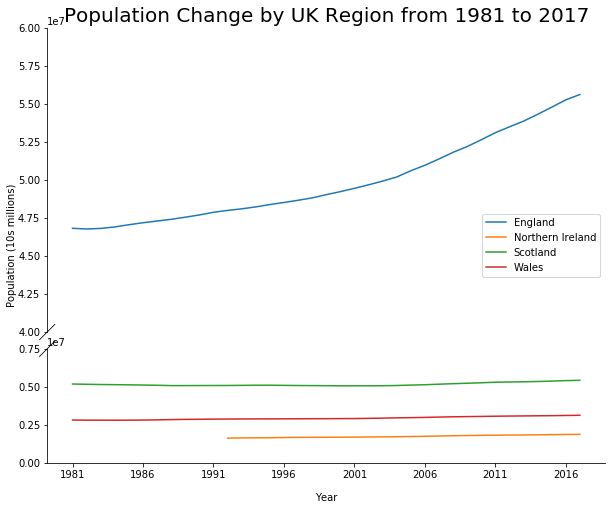

In [17]:
england = total_population_by_region[total_population_by_region.geography == 'England'][['geography', 'date', 'Value']]
northern_ireland = total_population_by_region[total_population_by_region.geography == 'Northern Ireland'][['geography', 'date', 'Value']]
scotland = total_population_by_region[total_population_by_region.geography == 'Scotland'][['geography', 'date', 'Value']]
wales = total_population_by_region[total_population_by_region.geography == 'Wales'][['geography', 'date', 'Value']]

fig = plt.figure(figsize=(10, 8))

bax = brokenaxes(ylims=((0, 0.75e7), (4e7, 6e7)), hspace=.08)

bax.plot(england.date, england.Value, label='England')
bax.plot(northern_ireland.date, northern_ireland.Value, label='Northern Ireland')
bax.plot(scotland.date, scotland.Value, label='Scotland')
bax.plot(wales.date, wales.Value, label='Wales')
bax.set_xlabel('Year')
bax.set_ylabel('Population (10s millions)')


plt.xticks(rotation='vertical')
plt.title('Population Change by UK Region from 1981 to 2017', fontsize=20)
bax.legend(loc=5)

In [18]:
#percentage increase
def get_percentage_increase(df):
    return (df[df.date == df.date.max()].iloc[0].Value - df[df.date == df.date.min()].iloc[0].Value) / df[df.date == df.date.min()].iloc[0].Value

print('England', get_percentage_increase(england))
print('Northern Ireland', get_percentage_increase(northern_ireland))
print('Scotland', get_percentage_increase(scotland))
print('Wales', get_percentage_increase(wales))

England 0.1879207531695315
Northern Ireland nan
Scotland 0.047218254121462494
Wales 0.11078727563532965


In [19]:
# UK population by age group

Text(0,0.5,'Percentage (%)')

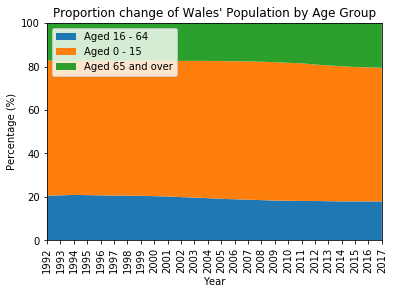

In [20]:
wales_demographics = df[(df.geography == 'Wales') & (df.sex == 'Total') & (df.age != 'All ages') & (df.measures == 'Percent')]

chart_data = pd.DataFrame({
    'date': wales_demographics.date.unique().tolist()
}, index=range(1,38))

for age_group in wales_demographics.age.unique()[-3:]:
    chart_data[str(age_group)] = wales_demographics[(wales_demographics.age == age_group)].Value.tolist()

plt.stackplot(chart_data.date, chart_data['Aged 0 - 15'],  chart_data['Aged 16 - 64'],  chart_data['Aged 65 and over'], labels=chart_data.columns[1:])
plt.xticks(rotation='vertical')
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Proportion change of Wales\' Population by Age Group')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')

Text(0,0.5,'Percentage (%)')

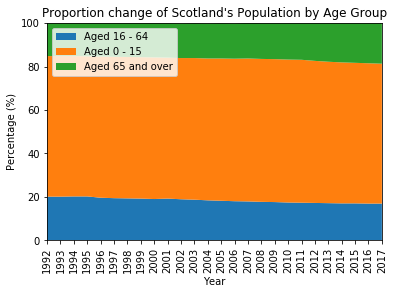

In [21]:
scotland_demographics = df[(df.geography == 'Scotland') & (df.sex == 'Total') & (df.age != 'All ages') & (df.measures == 'Percent')]

chart_data = pd.DataFrame({
    'date': scotland_demographics.date.unique().tolist()
}, index=range(1,38))

for age_group in scotland_demographics.age.unique()[-3:]:
    chart_data[str(age_group)] = scotland_demographics[(scotland_demographics.age == age_group)].Value.tolist()

plt.stackplot(chart_data.date, chart_data['Aged 0 - 15'],  chart_data['Aged 16 - 64'],  chart_data['Aged 65 and over'], labels=chart_data.columns[1:])
plt.xticks(rotation='vertical')
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Proportion change of Scotland\'s Population by Age Group')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')

Text(0,0.5,'Percentage (%)')

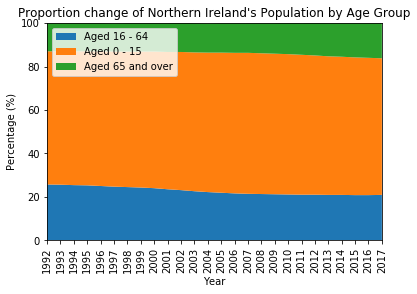

In [22]:
northern_ireland_demographics = df[(df.geography == 'Northern Ireland') & (df.sex == 'Total') & (df.age != 'All ages') & (df.measures == 'Percent')]

chart_data = pd.DataFrame({
    'date': northern_ireland_demographics.date.unique().tolist()
}, index=range(1,38))

for age_group in northern_ireland_demographics.age.unique()[-3:]:
    chart_data[str(age_group)] = northern_ireland_demographics[(northern_ireland_demographics.age == age_group)].Value.tolist()

plt.stackplot(chart_data.date, chart_data['Aged 0 - 15'],  chart_data['Aged 16 - 64'],  chart_data['Aged 65 and over'], labels=chart_data.columns[1:])
plt.xticks(rotation='vertical')
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Proportion change of Northern Ireland\'s Population by Age Group')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')

Text(0.5,1,"Proportion change of England's Population by Age Group")

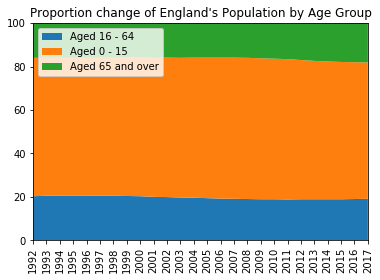

In [23]:
england_demographics = df[(df.geography == 'England and Wales') & (df.sex == 'Total') & (df.age != 'All ages') & (df.measures == 'Percent')]

chart_data = pd.DataFrame({
    'date': england_demographics.date.unique().tolist()
}, index=range(1,38))

for age_group in england_demographics.age.unique()[-3:]:
    chart_data[str(age_group)] = england_demographics[(england_demographics.age == age_group)].Value.tolist()

plt.stackplot(chart_data.date, chart_data['Aged 0 - 15'],  chart_data['Aged 16 - 64'],  chart_data['Aged 65 and over'], labels=chart_data.columns[1:])
plt.xticks(rotation='vertical')
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Proportion change of England\'s Population by Age Group')

In [24]:
england_and_wales_demographics = df[(df.geography == 'England and Wales') & (df.sex == 'Total') & (df.age != 'All ages') & (df.measures == 'Value')]
england_and_wales_demographics.head()

,geography,date,sex,age,measures,Value
552,England and Wales,1981,Total,Aged under 1 year,Value,634100.0
554,England and Wales,1981,Total,Aged 1 - 4 years,Value,2371500.0
556,England and Wales,1981,Total,Aged 5 - 9 years,Value,3196300.0
558,England and Wales,1981,Total,Aged 10 - 14 years,Value,3888700.0
560,England and Wales,1981,Total,Aged 15 - 19 years,Value,4129700.0


In [25]:
# For each year and age group
# * Find the "Value" for England only ("England and Wales" - "Wales") for that year and age group
# * Calculate percentage by dividing newly found "Value" by "Value" for "All ages"

In [26]:
england_and_wales_demographics = england_and_wales_demographics[~england_and_wales_demographics.Value.isnull()]

for year in england_and_wales_demographics.date.unique():
    for age_group in england_and_wales_demographics.age.unique()[-3:]:
        england_and_wales_pop = england_and_wales_demographics[(england_and_wales_demographics.date == year) & (england_and_wales_demographics.age == age_group)].iloc[0].Value
        wales_pop = wales_demographics[(wales_demographics.date == year) & (wales_demographics.age == age_group)].iloc[0].Value
        value = england_and_wales_pop - wales_pop

        england_and_wales_demographics = england_and_wales_demographics.append({'geography': 'England', 'date' : year, 'sex': 'Total', 'age': age_group, 'measures': 'Value', 'Value': value}, ignore_index=True)
        

IndexError: single positional indexer is out-of-bounds

In [ ]:
england_and_wales_demographics[england_and_wales_demographics.geography == 'England']